In [25]:
# Import the dependencies
import numpy as np
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
# import scipy.linalg as la
from scipy import signal
#from scipy.integrate import odeint
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

# Setting up the time data:
dt = 0.005; # integration time step, average neuron resets 200 times per second
T = 10+dt; # maximum time considered
t = np.arange(0,T,dt) # timline
N= t.size #Amount of data points
print ('Amount of data points: ', N)
print ('Starting with', t[0:5])
print ('Ending with', t[N-5:N])
pri nt ('Data elements', np.size(t))

Amount of data points:  2002
Starting with [0.    0.005 0.01  0.015 0.02 ]
Ending with [ 9.985  9.99   9.995 10.    10.005]
Data elements 2002


In [26]:
# Support functions for generalised coordinates of motion

def generalize_extend(y,p):
    """
    Construct generalised value with embedding order p 
    By [y,0,0...]
    
    INPUTS:
        y       - Input sensory signal
        p       - embedding order (>0)
        
    OUTPUT:
        y_tilde - Generalised sensory signal
    """ 
    if p<0:
        # unknown embedding order, error
        raise ValueError('Embedding order < 0')    
    
    if np.shape(y)==(p+1, 1):
        # Generalised value, use it
        y_tilde=y;
        return y_tilde
    
    # Generalize sensory observation by adding zero's
    y_tilde = np.zeros((p+1,1))
    y_tilde[0] = y

    return y_tilde

def sensor_generalize_exact(y,p,x,v,u):
    """
    Construct generalised sensory observations with embedding order p 
    Generalize sensory observation by calculating the exact value 
    
    For this example it has been calculated upto 3 derivatives

    INPUTS:
        y       - Input sensory signal
        p       - embedding order (>0)
        x       - Hidden state, needed to calculate the exact higher derivatives
        
    OUTPUT:
        y_tilde - Generalised sensory signal
    """ 
    if p<0:
        # unknown embedding order, error
        raise ValueError('Embedding order < 0')       

    y_tilde = np.zeros((p+1,1))
    y_tilde[0] = y
    if p>=1:
        y_tilde[1] = dg_gp(x,v)*f_gp(x,v,u) 
    if p>=2:
        y_tilde[2] = ddg_gp(x,v)*f_gp(x,v,u)**2 + dg_gp(x,v)*df_gp(x,v,u)*f_gp(x,v,u)
    if p>=3:
        y_tilde[3] = dddg_gp(x,v)*f_gp(x,v,u)**3 + 2*ddg_gp(x,v)*f_gp(x,v,u)**2*df_gp(x,v,u) + df_gp(x,v,u)*(ddg_gp(x,v)*f_gp(x,v,u)**2 + dg_gp(x,v)*df_gp(x,v,u)*f_gp(x,v,u))
    
    return y_tilde

def sensor_generalize_backward(y,i,p):
    """
    Construct generalised sensory observations with embedding order p 
    Generalize sensory observation by approximating the derivaties from past observations
    
    For this example it has been calculated upto 4 derivatives
    
    INPUTS:
        y       - Input sensory signal (array including all history thus far)
        i       - Current timestamp, so y[i] is the current non-generalised sensory signal
        p       - embedding order (>=0)
        
    OUTPUT:
        y_tilde - Generalised sensory signal
    """ 
    if p<0:
        # unknown embedding order, error
        raise ValueError('Embedding order < 0')    
    
    y_tilde = np.zeros((p+1,1))
    y_tilde[0] = y[i]
    if p>=1:
        y_tilde[1] = (y[i]-y[i-1])/dt
        #print('Generalise backward input : ', y[i],' + ',y[i-1])
    if p>=2 and i>=2:
        y_tilde[2] = (y[i]-2*y[i-1]+y[i-2])/dt**2
        #print('Generalise backward input : ', y[i],' + ',y[i-1],' + ',y[i-2])
    if p>=3 and i>=3:
        y_tilde[3] = (y[i]-3*y[i-1]+3*y[i-2]-y[i-3])/dt**3
        #print('Generalise backward input : ', y[i],' + ',y[i-1],' + ',y[i-2],' + ',y[i-3])
    if p>=4 and i>=4:
        y_tilde[4] = (y[i]-4*y[i-1]+6*y[i-2]-4*y[i-3]+y[i-4])/dt**4
        #print('Generalise backward input : ', y[i],' + ',y[i-1],' + ',y[i-2],' + ',y[i-3],' + ',y[i-4])
          
    return y_tilde

  

Temperature at 25 centimetres is:  17.0  degrees celsius


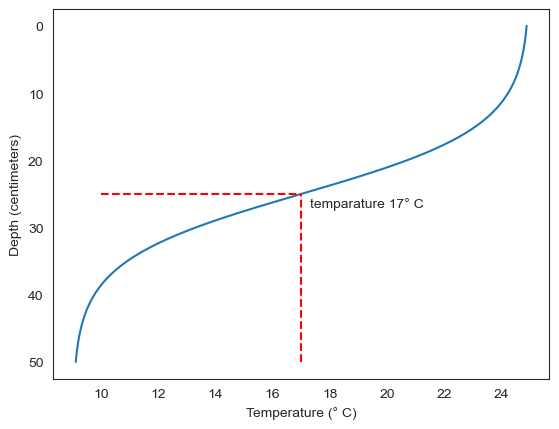

In [27]:
a_gp=0
b_gp=1
def f_gp(x, v, u):
    """
    Generative process, equation of motion: f_gp(x,u)    
   
    INPUTS:
        x       - Hidden state, depth position in centimetres
        v       - Causal state
        u       - Control signal
        
    OUTPUT:
        f_gp(x,v,u) - motion (speed) of the hidden state (depth) 
        
    """
    return a_gp*x + b_gp*u

def df_gp(x, v, u):
    """
    Partial derivative of generative process towards x, equation of motion: f'_gp(x,v,u) at point x    
   
    INPUTS:
        x       - Hidden state, depth position in centimetres
        v       - Causal state
        u       - Control signal
        
    OUTPUT:
        df_gp(x, u) - first derivative of the equation of motion towards x
        
    """
    return a_gp

def g_gp(x,v):
    """
    Generative process, equation of sensory mapping: g_gp(x,v)   
   
    INPUTS:
        x       - Hidden state, depth position in centimetres
        v       - Hidden causal state, in this example not used
        
    OUTPUT:
        g_gp(x,v) - Temperature in degrees celsius
        
    """

    t0=25
    return t0 -16 / (1 + np.exp(5-x/5))

def dg_gp(x,v):
    """
    Partial derivative of generative process towards x, equation of sensory mapping: g'_gp(x,v)   
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g'_gp(x,v) - first partial derivative of generative process towards x
        
    """
    
    return -16/5 * np.exp(5-x/5) / (1+np.exp(5-x/5))**2

def ddg_gp(x,v):
    """
    Double partial derivative of generative process towards x, equation of sensory mapping: g''_gp(x) 
    Needed to calculate the sensory signal in generalised motions
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g''_gp(x,v) - second partial derivative of generative process towards x
        
    """
    
    return (32*np.exp((2*x)/5+5))/(25*(np.exp(x/5)+np.exp(5))**3)-(16*np.exp(x/5+5))/(25*(np.exp(x/5)+np.exp(5))**2)

def dddg_gp(x,v):
    """
    3rd partial derivative of generative process towards x, equation of sensory mapping: g'''_gp(x)  
    Needed to calculate the sensory signal in generalised motions
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g'''_gp(x,v) - third partial derivative of generative process towards x
        
    """
    
    return -16*np.exp(x/5+5)*(np.exp((2*x)/5)-4*np.exp(x/5+5)+np.exp(10))/(125*(np.exp(x/5)+np.exp(5))**4)

def ddddg_gp(x,v):
    """
    4th partial derivative of generative process towards x, equation of sensory mapping: g''''_gp(x)  
    Needed to calculate the sensory signal in generalised motions
   
    INPUTS:
        x       - Position in centimetres    
        
    OUTPUT:
        g''''_gp(x,v) - 4th partial derivative of generative process towards x
        
    """
    
    return (16*np.exp(x/5+5)*(np.exp((3*x)/5)-11*np.exp((2*x)/5+5)+11*np.exp(x/5+10)-np.exp(15)))/(625*(np.exp(x/5)+np.exp(5))**5)

# in case you wondered how to calculated all the derivatives in an easy way: https://www.derivative-calculator.net/

# Show the temperature curve
x_show = np.arange (0,50,0.01)
y_show = g_gp(x_show,0)
dy_show = dg_gp(x_show,0)
plt.plot(y_show, x_show)
#plt.plot(dy_show, x_show)
plt.ylabel('Depth (centimeters)')
plt.xlabel('Temperature (° C)')
plt.gca().invert_yaxis()
plt.vlines(17, 50, 25, colors='r', linestyles='dashed')
plt.hlines(25, 10,17, colors='r', linestyles='dashed')
plt.text(17.3,27,"temparature 17° C")
plt.show;

print('Temperature at 25 centimetres is: ', g_gp(25,0), ' degrees celsius')

In [28]:
from PIL import Image, ImageDraw, ImageFont
import cv2

class Hydar_simulation_environment:
    def __init__(self, dt, t):
        """
        Class that creates the simulation environment, which is the generative process in active inference terminology.
        The simulation environment has the same structure as GYM reeinforcement Learning (RL) environment. 
        During a step the simulation environment gets the action from the agent and outputs the sensory observations as a result. 
        In contrast to RL, there is no reward given. 
        The boolean done signal is not used, the timeline (t) determines the simulation length 1..t.size

        version 0.1 including the ability to generate a video

        INPUTS:
            dt      - integration time step
            t       - timeline

        Don't forget to reset the environment when starting a new simulation 
        
        INTERNAL:
        x[i]        - depth of Hydar at timestamp i, the hidden state 
        y[i]        - temperature of Hydar at timestamp i, the sensory state
        u[i]        - action taken resulting in x[i], y[i] at timestamp i
        """

        # Action and observation space
        # self.action_space = ((-inf, inf), (-5.0, 5.0))
        # self.action_space = float64
        # self.observation_space = float64

        self.dt = dt # integration time step
        self.N= t.size # amount of data points
        self.t=t # timeline
        
        # Images for the rendering
        self.water_image = Image.open("/kaggle/input/graphics/hydar_water_background.jpg").resize((1000, 750))  # water background 4000x3000 pixels
        self.hydar_image_large = Image.open("/kaggle/input/graphics/hydar.png") # hydar image 246*208
        self.hydar_image = self.hydar_image_large.resize((65, 50)) 



    def reset(self, v, x_init, Sigma2_x, Sigma2_y, s2, noise_method, p, gen_y_method):
        """
        Reset the environment to its initial state
        To be executed before a new simulation
        
        INPUTS:
        v             - Generative model causal state
        x_init        - Hydars actual starting depth, used in generative model
        Sigma2_x      - Variance of the hidden state mu_x
        Sigma2_y      - Variance of the sensory observation mu_y
        s2            - Temporal smoothness , variance of the Gaussian convolution filter to create colored noise            - 
        noise_method  - white, smooth or none
        p             - Embedding order of generalised motions of the generative model
        gen_y_method  - Method to generalize the sensory observations: exact, backward, extend
        """
        
        self.x = np.zeros(self.N) # Depth sequence
        self.y = np.zeros(self.N) # Temperature sequence= Sensory signal   
        self.u = np.zeros(self.N) # Action sequence 
        self.v = v                # generative model hidden cause
        self.x[0] = x_init        # starting position
        self.Sigma2_x = Sigma2_x  # Variance of the hidden state 
        self.Sigma2_y = Sigma2_y  # Variance of the sensory observation 
        self.noise_method = noise_method # noise method 
        self.s2 = s2              # Temporal smoothness, variance of the filter
        self.p = p # Embedding order of generalised motions, only needed to generate the sensory observations in generalised motions
        self.gen_y_method = gen_y_method # Method to generalize the sensory observations: exact, backward, extend
        self.i = 0                # timestep-counter

        
        # Construct noise signals with temporal smoothness if required:
        np.random.seed(42)
        if noise_method == 'smooth' or noise_method == 'colored':
            # And generate the smooth noise
            self.w = self.makeNoise(self.Sigma2_x,self.s2,self.t)
            self.z = self.makeNoise(self.Sigma2_y,self.s2,self.t)

        if noise_method == 'white':
            self.y[0]=g_gp(self.x[0],self.v) + np.random.randn(1) * np.sqrt(self.Sigma2_y)
        elif noise_method == 'smooth' or noise_method == 'colored':
            self.y[0]=g_gp(self.x[0],self.v)+ self.z[0,0] 
        else: #no noise
            self.y[0]=g_gp(self.x[0],self.v)
            
        y_tilde=generalize_extend(self.y[0],self.p)
        
        # Create the initial sensory observation with the correct embedding order / method
        if self.p==0:
            y_tilde = self.y[0]
        if self.gen_y_method=='exact':
            y_tilde = sensor_generalize_exact(self.y[0],self.p,self.x[0],self.v,0)
            #print(y_tilde)
        elif self.gen_y_method=='backward':
            y_tilde = sensor_generalize_backward(self.y,0,self.p)
        elif self.gen_y_method=='extend':
            y_tilde = generalize_extend(self.y[0],self.p)
        else:
            raise ValueError('Unknown method to create sensory observation in generalised coordinates of motion')
        
        return y_tilde 
    
    def makeNoise(self, C, s2, t):
        """
        Generate random noise series with temporal smoothness with desired covariance matrix
        Code by Sherin Grimbergen (V1 2019) and Charel van Hoof (V2 2020)

        INPUTS:
            C       - desired covariance matrix
            s2      - smoothness parameter (>0), variance of the filter (sigma^2)
                      - s2 <= 1e-5 -> produces white noise
            t       - timeline 

        OUTPUT:
            ws       - noise sequence with temporal smoothness
        """

        if np.size(C)== 1:
            n = 1
        else:
            n = C.shape[1]  # dimension of noise

        # Create the white noise with correct covariance
        N = np.size(t)      # number of elements
        L =cholesky(C, lower=True)  #Cholesky method
        w = np.dot(L,np.random.randn(n,N))

        if s2 <= 1e-5: # return white noise
            return w
        else: 
            # Create the noise with temporal smoothness
            P = toeplitz(np.exp(-t**2/(2*s2)))
            F = np.diag(1./np.sqrt(np.diag(np.dot(P.T,P))))
            K = np.dot(P,F)
            ws = np.dot(w,K)
            return ws
    
    def step(self, action):

        assert isinstance(action, float), "Action must be a float!"
        
        i=self.i # to keep the code readable
                
        if i >= self.N-1:
                raise ValueError('Error, simulation step > timeline') 
                   
        # Environment's dynamics
        if self.noise_method == 'white':
            x_dot= f_gp(self.x[i],self.v, action) + np.random.randn(1) * np.sqrt(self.Sigma2_x)
            self.x[i+1]= self.x[i] + self.dt*x_dot
            self.y[i+1] = g_gp(self.x[i+1],self.v) + np.random.randn(1) * np.sqrt(self.Sigma2_y)
        elif self.noise_method == 'smooth' or self.noise_method == 'colored':
            x_dot= f_gp(self.x[i],self.v,action) + self.w[0,i]
            self.x[i+1]= self.x[i] + self.dt*x_dot
            self.y[i+1] = g_gp(self.x[i+1],self.v) + self.z[0,i]
        else: #no noise
            x_dot=f_gp(self.x[i],self.v,action)
            self.x[i+1]= self.x[i] + self.dt*x_dot
            self.y[i+1] = g_gp(self.x[i+1],self.v)

        self.u[i+1]=action
        
         # Create the sensory observations with the requested embedding order / method
        if self.p==0:
            y_tilde = self.y[i+1]
        if self.gen_y_method=='exact':
            y_tilde = sensor_generalize_exact(self.y[i+1],self.p,self.x[i+1],self.v,action)
            #print(y_tilde)
        elif self.gen_y_method=='backward':
            y_tilde = sensor_generalize_backward(self.y,i+1,self.p)
        elif self.gen_y_method=='extend':
            y_tilde = generalize_extend(self.y[i+1],self.p)
        else:
            raise ValueError('Unknown method to create sensory observation in generalised coordinates of motion')   
        
        
        self.i = self.i+1
        
        info = "" # Additional information, if needed
        
        if self.i>= self.N-1:
            done=True
        else:
            done=False
        
        return y_tilde, 0, done, info

    
    def render(self,i, max_depth=50, mu_x=None, mu_v=None, prior=None, actiontime=None, mode='human'):
        """
        Draw a frame/image of Hydar in the water at timestep i
        Additional data can be given as input to be displayed in image as well.

        INPUTS:

        i           - timestep to be shown 
        mode        - output type human (show on screen), rgb_array (frame for video)
        prior       - optional additional time series with the prior
        mu_x        - optional additional time series with the hidden state
        mu_v        - optional additional time series with the causal state
        actiontime  - optional additional timestep when action is enabled
        """
        
        # Create a copy of the water image so as not to modify the original
        frame = self.water_image.copy()
        
        # The Hydar image's alpha channel is used as the mask
        mask = self.hydar_image.convert("RGBA").split()[-1]
        
        # Use the max depth to scale the depth
        scaler = (self.water_image.height - self.hydar_image.height) / max_depth
        depth = int(self.x[i] * scaler )
        
        # Calculate the amount of colums/data to be shown
        column = 2 # always shown depth and temperature
        if mu_x!=None: column=column+1
        if mu_v!=None: column=column+1
        if prior!=None: column=column+1
        colum_width_major=int(frame.width*2/10)
        colum_width_minor=int(frame.width*1/10)
        # the horzontal position of Hydar
        if column==2:
            xpos=int(frame.width*1/2)
        else:
            xpos=int(frame.width*1/3) 
        if actiontime==None:
            # if no action time is given do show all actions
            actiontime=0
        
        # Draw the hydar image at the specified x,y coordinate (y=depth)
        frame.paste(self.hydar_image, (xpos, depth ), mask=mask) 
        
        draw = ImageDraw.Draw(frame)
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",30)
        except IOError:
            print("Font not found, using default font.")
            font = ImageFont.load_default()
            
        # Draw an orange horizontal line at the depth of hydra and show depth
        draw.line((int(xpos + self.hydar_image.width), depth, int(xpos + self.hydar_image.width+colum_width_major), depth), fill="orange", width=3)      
        draw.text((int(xpos + self.hydar_image.width), depth), "Depth: " + "{:.2f}".format(self.x[i]), fill="white", font=font)
        
        # Draw a red horizontal line at the depth of hydra and show temperature
        draw.line((int(xpos-colum_width_major), depth, int(xpos), depth), fill="red", width=3)      
        draw.text((int(xpos-colum_width_major), depth), "Temp: " + "{:.2f}".format(self.y[i]), fill="white", font=font)
       
        # Draw the clock bottom left
        draw.text((int(frame.width*1/10)+10, frame.height-50), "Time: " + "{:.2f}".format(self.t[i]), fill="white", font=font)
        
        # Draw propulsion  
        if i>=actiontime:
            draw.text((int(xpos + self.hydar_image.width/2+10), depth+60), "Propulsion: " + "{:.2f}".format(self.u[i]), fill="white", font=font)
            draw.line((int(xpos + self.hydar_image.width/2), depth+self.hydar_image.height+10, int(xpos + self.hydar_image.width/2), depth+self.hydar_image.height+50), fill="orange", width=3)
        else:
            draw.text((int(xpos + self.hydar_image.width/2+10), depth+60), "Action disabled", fill="white", font=font)
            
        if self.u[i]<0 and i>=actiontime:
            # negative propulsion is moving up, Arrow up
            arrowhead = [
                (int(xpos + self.hydar_image.width/2), depth+self.hydar_image.height+10),  # Tip of the arrow
                (int(xpos + self.hydar_image.width/2) - 5, depth+self.hydar_image.height+20), # Left base of the arrowhead
                (int(xpos + self.hydar_image.width/2) + 5, depth+self.hydar_image.height+20)]  # Right base of the arrowhead
            draw.polygon(arrowhead, fill="orange")
        elif self.u[i]>0 and i>=actiontime:
            # positive propoulsion is moving down, arrow down
            arrowhead = [
                (int(xpos + self.hydar_image.width/2), depth+self.hydar_image.height+50),  
                (int(xpos + self.hydar_image.width/2) - 5, depth+self.hydar_image.height+40),
                (int(xpos + self.hydar_image.width/2) + 5, depth+self.hydar_image.height+40)]
            draw.polygon(arrowhead, fill="orange")
        #else:
          #  ; #No propulsion thus no arrow head, do nothing
        
        # draw additional data in the image if given
        count=0
        if prior!=None:
            count=count+1
            draw.line((int(frame.width*9/10-colum_width_minor*count), prior*scaler, int(frame.width*9/10-colum_width_minor*(count-1)), prior*scaler), fill="black", width=3)      
            draw.text((int(frame.width*9/10-colum_width_minor*count ), prior*scaler), " "+"{:.2f}".format(prior), fill="white", font=font) 
            draw.text((int(frame.width*9/10-colum_width_minor*count ), prior*scaler-40), " prior", fill="white", font=font) 
        if mu_v!=None:
            count=count+1
            draw.line((int(frame.width*9/10-colum_width_minor*count), mu_v*scaler, int(frame.width*9/10-colum_width_minor*(count-1)), mu_v*scaler), fill="purple", width=3)      
            draw.text((int(frame.width*9/10-colum_width_minor*count ), mu_v*scaler), " "+"{:.2f}".format(mu_v), fill="white", font=font) 
            draw.text((int(frame.width*9/10-colum_width_minor*count ), mu_v*scaler-40), " mu_v", fill="white", font=font) 
        if mu_x!=None:
            count=count+1
            draw.line((int(frame.width*9/10-colum_width_minor*count), mu_x*scaler, int(frame.width*9/10-colum_width_minor*(count-1)), mu_x*scaler), fill="green", width=3)      
            draw.text((int(frame.width*9/10-colum_width_minor*count ), mu_x*scaler), " "+"{:.2f}".format(mu_x), fill="white", font=font) 
            draw.text((int(frame.width*9/10-colum_width_minor*count ), mu_x*scaler-40), " mu_x", fill="white", font=font) 

            
        # draw the scales
        for divider in np.linspace(0, max_depth, 5):
            draw.line((int(frame.width*9/10), divider * scaler , int(frame.width), divider * scaler ), fill="orange", width=3)      
            draw.text((int(frame.width*9/10), divider * scaler ), " " + "{:.2f}".format(divider), fill="white", font=font)
            draw.line((int(frame.width*1/10), divider * scaler , int(0), divider * scaler ), fill="red", width=3)      
            draw.text((int(1), divider * scaler ), " " + "{:.2f}".format(g_gp(divider,0)), fill="white", font=font)
    
        if mode == 'rgb_array':
            return np.array(frame)
        
        plt.axis('off') # to turn off axes
        plt.imshow(frame)
        plt.show()
        
    def render_credits (self, credittext=None,  mode='human'):
        """
        Draw a credits screen

        """
        
        # Create a copy of the water image so as not to modify the original
        frame = self.water_image.copy()
        
        # The Hydar image's alpha channel is used as the mask
        mask = self.hydar_image_large.convert("RGBA").split()[-1]
        
        draw = ImageDraw.Draw(frame)
        try:
            font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",30)
        except IOError:
            print("Font not found, using default font.")
            font = ImageFont.load_default()
        
        try:
            font_small = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",20)
        except IOError:
            print("Font not found, using default font.")
            font_small = ImageFont.load_default()
        
        if credittext!=None:
            draw.text((int(frame.width*1.5/10), int(frame.height*1/10)), credittext, fill="white", font=font)
 
        # Draw the hydar image at the specified x,y coordinate (y=depth)
        frame.paste(self.hydar_image_large, (int(frame.width/2-self.hydar_image_large.width/2), int(frame.height*9/10-self.hydar_image_large.height) ), mask=mask) 
       
        # Draw the credits bottom left
        draw.text((int(frame.width*1/100), frame.height-30), "Water photo by Cristian Palmer on unsplash.com", fill="white", font=font_small)
   

        if mode == 'rgb_array':
            return np.array(frame)
        
        plt.axis('off') # to turn off axes
        plt.imshow(frame)
        plt.show()
        
    def save_data (self):
        """
        This function saves results/data for reporting
        """
        return self.x , self.y, self.u


    def save_as_video(self, filename="hydar.avi", mu_x=None, mu_v=None, prior=None, actiontime=None, credittext=None):
        """
        This function saves the results as a video. 
        Additional data can be given as input to be displayed in the video as well.

        INPUTS:

        filename    - avi video filename (xxx.avi) 
        prior       - optional additional time series with the prior
        mu_x        - optional additional time series with the hidden state
        mu_v        - optional additional time series with the causal state
        actiontime  - optional additional timestep when action is enabled
        """    
        # Scale the max depth with the height of the video/image
        max_depth=int(max(self.x)*1.2)
        
        # Create the frames of the video
        frames = [] # list to hold the frames   

        # generate tile screen of the experiment with the experiment info, can be read as still
        for i in range (10): # first image(s) , to be read as still
            frame = self.render_credits(mode='rgb_array', credittext=credittext)
            frames.append(frame)
        
        # generate the main video
        for i in range(N) :
            prior_step = prior if prior is None else prior[i]
            mu_x_step = mu_x if mu_x is None else mu_x[i]
            mu_v_step = mu_v if mu_v is None else mu_v[i]

            frame = self.render(i, max_depth= max_depth, mu_x=mu_x_step, mu_v=mu_v_step, prior= prior_step,mode='rgb_array', actiontime=actiontime)
            frames.append(frame)

        # generate credits screen of the experiment with the experiment info, can be read as still
        for i in range (3): # last image(s) , to be read as still
            frame = self.render_credits(mode='rgb_array', credittext=credittext)
            frames.append(frame)
        
        # Define the codec using VideoWriter_fourcc and create VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        frame_height, frame_width, _ = frames[0].shape
        out = cv2.VideoWriter(filename, fourcc, 1/self.dt, (frame_width, frame_height))

        # convert frames to BGR and save as video
        for f in frames:
            # Convert from RGB to BGR
            f = cv2.cvtColor(f, cv2.COLOR_RGB2BGR)
            #output to the video file
            out.write(f)
        out.release()

        
# Example usage
env = Hydar_simulation_environment(dt,t)
observation = env.reset(0,15,0.1,0.1,1,'no noise',1,'extend')
env.render(0, prior=25, mu_x=15, mu_v=25, actiontime=20)
#env.render_credits(credittext="test")

ModuleNotFoundError: No module named 'cv2'

In [ ]:
class ai_capsule():
    """
        Class that constructs a group of neurons that perform Active Inference for one hidden state, one sensory input, one causal state
        In neurology it could e.g. represent a neuron assembly

        Version 0.4 including generalised coordinates of motion, hidden state estimation, causal state estimation, action
        
    """
    def __init__(self, dt, t, mu_x_init, mu_v_init, p, Sigma2_x, Sigma2_y, Sigma2_v, a_mu_x, a_mu_v, a_u, s2, fwd_method, actiontime):  
        
        """
                INPUTS:
        dt               - integration time step
        t                - timeline
        mu_x_init        - initial hidden state estimation, in generalised coordinates of motion
        mu_v_init        - initial hidden cause estimation, in generalised coordinates of motion
        p                - embedding order generative model, number of derevatives in generalised coordinates of motion
        Sigma2_x         - Estimated variance of the hidden state mu_x
        Sigma2_y         - Estimated variance of the sensory observation mu_y
        Sigma2_v         - Estimated variance of the prior mu_v
        a_mu_x           - perception learning rate mu_x
        a_mu_v           - perception learning rate mu_v
        a_mu_a           - action learning rate
        s2               - Temporal smoothness , variance of the Gaussian convolution filter to create colored noise
        gen_y_method     - Method to generalize the sensory observations: exact, backward, extend
        fwd_method       - Method for the foward model: exact, sign
        actiontime       - timestep when action is enabled
        """
        
        self.dt = dt # integration time step
        self.N= t.size # amount of data points
        self.t=t # timeline
        self.mu_x = [np.zeros((p+1, 1)) for _ in range(N)] # hidden state estimation over time in generalised coordinates of motion
        self.mu_v = [np.zeros((p+1, 1)) for _ in range(N)] # causal state estimation over time in generalised coordinates of motion
        self.mu_y = np.zeros(self.N)  # sensory state estimation over time 
        self.u = np.zeros(self.N) 
        self.F= np.zeros(self.N) 
        self.mu_x[0]= mu_x_init # initializing the hidden state, in generalised coordinates of motion
        self.mu_v[0]= mu_v_init # initializing the hidden cause, in generalised coordinates of motion
        self.u[0] = 0      # initialize the control signal as 0, no action
        self.mu_y[0]= self.g(self.mu_x[0][0],self.mu_v[0][0])
        self.p = p      
        self.Sigma2_x = Sigma2_x 
        self.Sigma2_y = Sigma2_y 
        self.Sigma2_v = Sigma2_v 
        self.s2 = s2
        self.alpha_mu_x = a_mu_x 
        self.alpha_mu_v = a_mu_v 
        self.alpha_u = a_u  
        self.D = self.derivativeD(self.p)
        self.I = np.identity(self.p+1)
        self.Iv = np.ones((p+1,1))
        self.temporalcovariance = self.temporalC(self.p,self.s2)
        self.Pi_x = inv(np.kron(self.temporalcovariance,self.Sigma2_x)) # precision matrix of smoothened noise w
        self.Pi_y = inv(np.kron(self.temporalcovariance,self.Sigma2_y)) # precision matrix of smoothened noise z
        self.Pi_v = inv(np.kron(self.temporalcovariance,self.Sigma2_v)) # precision matrix of smoothened noise z
        self.std_vec_inv=self.standard_vec_inv(p)
        self.std_vec=self.standard_vec(p)
        self.fwd_method = fwd_method
        self.actiontime = actiontime
        self.i = 0 # timestep-counter
               
        # Generative model parameters
        self.a=-1 # generative model function of motion is -mu_x + mu_v, hence a = -1
        self.b=1 # generative model function of motion is -mu_x + mu_v, hence b = 1
        self.Atilde=self.a * self.I
        self.Btilde=self.b * self.I
        #self.c=1 # uncomment in case you want to test a linear model for sensory observations
        #self.Ctilde= self.c * self.I # uncomment in case you want to tst a linear model for sensory observations
 
        if self.p<0:
            # unknown embedding order, error
            raise ValueError('Embedding order forward model < 0')    
        if self.p==0:
            # unknown embedding order, error
            raise ValueError('This active inference neuron class is not designed for p=0, p should be at least 1')    

    def g(self,x,v):
        """
            equation of sensory mapping of the generative model: g(x,v)  
            Given as input for this example equal to the true generative process g_gp(x,v)
        """
        return g_gp(x,v)
    
    def dx_dg(self, x,v):
        """
            Partial derivative of the equation of sensory mapping of the generative model towards x: g'(x,v) towards x 
            Given as input for this example equal to the true derivative of generative process dg_gp(x,v) towards x
        """
        return dg_gp(x,v)
    
    def dv_dg(self, x,v):
        """
            Partial derivative of the equation of sensory mapping of the generative model towards x: g'(x,v) towards v 
            Given as input for this example equals to 0 (not dependend on v)
        """
        return 0
    
    def f(self,x,v):
        """
            equation of motion of the generative model: f(x,v) 
            f(x,v) = a* mu_x + b* mu_v, where a = -1, b=1
        """
        return self.a*x + self.b*v
    
    def dx_df(self,x,v):
        """
            Partial derivative of equation of motion of the generative model: f'(x,v) towards x 
        """
        return self.a
    
    def dv_df(self, x, v):
        """
            Partial derivative of equation of motion of the generative model: f'(x,v) towards v 
        """
        return self.b
    
    def fwd_model(self, x, v, u, fwd_method):
        """
        Construct the forward model embedding order p 
        see: https://www.kaggle.com/code/charel/learn-by-example-active-inference-in-the-brain-5
        
        For this example the exact method has been calculated upto 3 derivatives

        INPUTS:
            x          - Hidden state
            v          - Hidden cause
            u          - Control signal
            fwd_method - Method

        OUTPUT:
            fwd        - Forward model
        """ 
   
        if fwd_method == 'sign':
            fwd = np.sign(dg_gp(x,v)) * np.ones((self.p+1,1))
        elif fwd_method == 'exact':        
            fwd = np.zeros((self.p+1,1))
            if self.p>=1:
                fwd[1] = b_gp*dg_gp(x,v)
            if self.p>=2:
                fwd[2] = 2*b_gp*f_gp(x,v,u)*ddg_gp(x,v) +b_gp*df_gp(x,v,u)*dg_gp(x,v)
            if self.p>=3:
                fwd[3] = 3*b_gp*f_gp(x,v,u)**2*dddg_gp(x,v)+4*df_gp(x,v,u)*b_gp*f_gp(x,v,u)*dg_gp(x,v)+2*df_gp(x,v,u)*b_gp*f_gp(x,v,u)*ddg_gp(x,v)+df_gp(x,v,u)**2*b_gp*dg_gp(x,v)
        elif fwd_method == 'sign+':        
            fwd = np.zeros((self.p+1,1))
            if self.p>=1:
                fwd[1] = np.sign(dg_gp(x,v))
            if self.p>=2:
                fwd[2] = np.sign(ddg_gp(x,v))
            if self.p>=3:
                fwd[3] = np.sign(dddg_gp(x,v))
        else:
            raise ValueError('Unknown method to create forward model')     

        return fwd
    
    def standard_vec(self, p):
        """
        Vector [1,0,0,0,0, etc] with embedding order p
        """
        x = np.zeros((p+1,1))
        x[0] = 1
        return x

    def standard_vec_inv(self, p):
        """
        Vector [0,1,1,1,1,1, etc] with embedding order p
        """
        x = np.ones((p+1,1))
        x[0] = 0
        return x
    
    def derivativeD(self, p):
        """
        Construct derivative operator with embedding order p 
        Shifts all variables of a vector up by one and adds a zero at the bottom 

        Code by Sherin Grimbergen (V1 2019) and Charel van Hoof (V2 2020)

        INPUTS:
            p       - embedding order (>0)

        OUTPUT:
            D       - derivative matrix ((p+1) x (p+1))
        """ 
        D = toeplitz(np.zeros([1,p+1]),np.append(np.array([0,1]),np.zeros([1,p-1])))

        return D
    
    def temporalC(self, p, s2):
        """
        Construct the temporal covariance matrix S for noise with embedding order p and smoothness parameter s2

        See: https://www.kaggle.com/code/charel/learn-by-example-active-inference-in-the-brain-2
        
        Code by Sherin Grimbergen (V1 2019) and Charel van Hoof (V2 2020)

        INPUTS:
            p       - embedding order (>0)
            s2      - smoothness parameter (>0), variance of the filter (sigma^2)

        OUTPUT:
            S       - temporal covariance matrix ((p+1) x (p+1))
        """ 

        q = np.arange(p+1)

        r = np.zeros(1+2*(p))
        r[2*q] = np.cumprod(1-2*q)/(2*s2)**(q)    

        S = np.empty([0,p+1])

        for i in range(p+1):
            S = np.vstack([S,r[q+i]])
            r = -r

        return S 
    
    def ai_step (self, prior, y):
        """
        Perform active inference step   

        INPUTS:
            prior   - target location of the hidden causes
            y       - sensory input signal at timestamp, in generalized coordinates of motion

        INTERNAL:
            i         - tic, timestamp
            mu_x      - Belief or hidden state estimation, in generalized coordinates of motion
            mu_y      - Belief or sensory signal estimation/prediction, in generalized coordinates of motion
            mu_v      - Belief or causal state estimation, in generalized coordinates of motion

        """

        i=self.i # to keep the code readable
                
        if i >= self.N-1:
                raise ValueError('Error, simulation step > timeline') 
        
        #-------------------------------#
        #                               #
        #           Prediction          #
        #                               #
        #-------------------------------#
        
        # Note that the predictions are in generalized coordinates of motion  
        mu_x_hat = self.std_vec*self.f(self.mu_x[i][0],self.mu_v[i][0]) + self.std_vec_inv * self.dx_df(self.mu_x[i][0],self.mu_v[i][0]) * self.mu_x[i] + self.std_vec_inv * self.dv_df(self.mu_x[i][0],self.mu_v[i][0]) * self.mu_v[i]
        mu_y_hat = self.std_vec*self.g(self.mu_x[i][0],self.mu_v[i][0]) + self.std_vec_inv * self.dx_dg(self.mu_x[i][0],self.mu_v[i][0]) * self.mu_x[i] + self.std_vec_inv * self.dv_dg(self.mu_x[i][0],self.mu_v[i][0]) * self.mu_v[i]
        
        #-------------------------------#
        #                               #
        #        Prediction Error       #
        #                               #
        #-------------------------------#

        # Note that the predictions erros are in generalized coordinates of motion 
        
        eps_x = self.D.dot(self.mu_x[i]) - mu_x_hat  # prediction error hidden state
        eps_y = y - mu_y_hat #prediction error sensory observation  
        
        # In case a linear state space model the prediction error can be written as (below calculation is equivalent):
        #eps_x = (self.D-self.Atilde).dot(self.mu_x) - self.Btilde.dot(self.mu_v)  # prediction error hidden state
        #eps_y = y - self.Ctilde.dot(self.mu_x) #prediction error sensory observation

        #-------------------------------#
        #                               #
        # Prediction Error minimization #
        #                               #
        #-------------------------------#            
     
        #-------------------------------------#
        # Calculate Free Energy to report out #
        #-------------------------------------#
        
        self.F[i+1]= 0.5*( eps_x.T.dot(self.Pi_x).dot(eps_x) + eps_y.T.dot(self.Pi_y).dot(eps_y)).item(0) 
        # Note, the item(0) is needed to translate the python matrix result to a scaler, e.g. [[1]] to 1
        
        #-------------------------------#
        # Gradient descent hidden state #
        #-------------------------------#
        
        dFdmu_x = (self.D-self.dx_df(self.mu_x[i][0],self.mu_v[i][0]) * self.I).T.dot(self.Pi_x).dot(eps_x) - (self.dx_dg(self.mu_x[i][0],self.mu_v[i][0]) * self.I ).T.dot(self.Pi_y).dot(eps_y)                       
        # In case a linear state space model is used the below calculation is equivalent
        #dFdmu_x = (self.D-Atilde).T.dot(self.Pi_x).dot(self.eps_x) - Ctilde.T.dot(self.Pi_y).dot(self.eps_y)
        
        dmu_x = np.dot(self.D,self.mu_x[i]) - self.alpha_mu_x * dFdmu_x  
        self.mu_x[i+1] = self.mu_x[i] + self.dt * dmu_x

        #-------------------------------#
        # Gradient descent causal state #
        #-------------------------------#
        
        eps_v = self.mu_v[i] - prior
        
        dFdmu_v = (-self.dv_df(self.mu_x[i][0],self.mu_v[i][0]) * self.I).T.dot(self.Pi_x).dot(eps_x) + (-self.dv_dg(self.mu_x[i][0],self.mu_v[i][0]) * self.I ).T.dot(self.Pi_y).dot(eps_y) + self.Pi_v.dot(eps_v)
        
        # In case a linear state space model is used the below calculation is equivalent
        #dFdmu_x = (-Ctilde).T.dot(self.Pi_x).dot(self.eps_x) + (self.Pi_v).dot(self.eps_p)
        
        dmu_v = np.dot(self.D,self.mu_v[i]) - self.alpha_mu_v * dFdmu_v  
        self.mu_v[i+1] = self.mu_v[i] + self.dt * dmu_v

        #-------------------------#
        # Gradient descent action #
        #-------------------------#
        
        if i>=self.actiontime:
            fwd=self.fwd_model(self.mu_x[i][0], self.mu_v[i][0], self.u[i], self.fwd_method)          
            dFdu = fwd.T.dot(self.Pi_y).dot(eps_y).item(0)
            du = -self.alpha_u * dFdu  
            self.u[i+1] = self.u[i] + self.dt * du
        else:
            self.u[i+1]=0.0
        
        self.mu_y[i+1]= self.g(self.mu_x[i][0],self.mu_v[i][0]) # todo, in generalised coordinates?
        self.i = self.i+1
        
        return self.u[i+1]
    
    def save_data (self):
        """
        This function saves results/data for reporting
        """
        return  self.F, self.mu_v, self.mu_x, self.mu_y, self.u

In [ ]:
def simulation (name,dt,t, v, prior, x_init, Sigma2_x, Sigma2_y, Sigma2_v, noise_method, a_mu_x,a_mu_v, a_u, p, gen_y_method, fwd_method, actiontime, video=False):
    """
    Simulation for perceptual inference in a dynamic environment with generalised coordinates     
   
    INPUTS:
        Name          - Name of the experiment
        v             - Generative model causal state
        prior         - Hydars top-down prior belief/hypotheses of the desired depth (time series)
        x_init        - Hydars actual starting depth, used in generative model
        Sigma2_x      - Variance of the hidden state mu_x
        Sigma2_y      - Variance of the sensory observation mu_y
        Sigma2_v      - Variance of the sensory observation mu_z
        noise_method  - white, smooth or none
        a_mu_x        - Learning rate for mu_x
        a_mu_v        - Learning rate for mu_v
        a_u           - Learning rate for u
        p             - Embedding order of generalised motions of the generative model
        gen_y_method  - Method to generalize the sensory observations: exact, backward, extend
        fwd_method    - Method for the foward model: exact, sign
        actiontime    - Timestep when action is enabled
    VARIABLES:
        s2            - The variance of the Gaussian filter used to create the smoothened noise
  
    """
    
    # this simulation code is for simulation with generalised coordinates of motion
    if p<=0:
        # Not generalised
        raise ValueError('Select embedding order p > 0') 
        
    
    # Initialize the variance of the gausian filter (e.g. to estimate/construct colored noise):
    np.random.seed(42)
    if noise_method == 'white':
        s2 = 1e-5
    elif noise_method == 'smooth' or noise_method == 'colored' :
        s2 = 1/2000
    else: #no noise
        s2 = 1/64   

    # Create the simulation environment
    env = Hydar_simulation_environment(dt,t)
    y=env.reset(v, x_init, Sigma2_x, Sigma2_y, s2, noise_method, p, gen_y_method)
    
    # make prior in generalised coordinates of motion
    prior_tilde = [generalize_extend(item, p) for item in prior] 
    
    # Create active inference neuron
    capsule = ai_capsule(dt, t, prior_tilde[0], prior_tilde[0], p, Sigma2_x, Sigma2_y, Sigma2_v, a_mu_x, a_mu_v, a_u, s2, fwd_method, actiontime) 

    # Run the simulation
    ssim = time.time() # start sim

    for i in np.arange(1,N):
        # Calculate action using active inference step using sensory observation       
        u = capsule.ai_step(prior_tilde[i],y)
        # Execute action in simulation environment step with resulting sensory observation (y)
        y, reward, done, info = env.step(u)
    tsim = time.time() - ssim
    #print('Simulation time: ' + "%.2f" % tsim + ' sec' )   
    
    # Get the data for reporting
    x, y, u = env.save_data()
    F, mu_v_new, mu_x_new, mu_y, same_u = capsule.save_data()

    # Use only the first entry of the generalised coordinates for reporting purposes  
    mu_x_0 = np.array([mu_x_e[0][0] for mu_x_e in mu_x_new])
    mu_v_0 = np.array([mu_v_e[0][0] for mu_v_e in mu_v_new])
    
    MSE=sum((mu_y-y)**2) # Mean Squared Error resulting sensory observation
    EFE=sum(F) # sum of the free energy over all timesteps can be regarded as the Expected Free Energy (of the future) at the start of the sequence
    
    if video==True:
        credittext = "Name: "+ name+"\n"
        credittext = credittext + "Sigma2_x= {:.2f},  Sigma2_y= {:.2f},  Sigma2_v= {:.2f} \n ".format(Sigma2_x,Sigma2_y,Sigma2_v)
        credittext = credittext + "LR mu_x= {:.2f}, LR u= {:.2f}, LR mu_v= {:.2f} \n ".format(a_mu_x,a_u,a_mu_v)
        credittext = credittext + "init x= {:.2f}, prior= {:.2f} \n ".format(x_init,prior[0])
        credittext = credittext + "init mu_x= {:.2f}, init u= 0, init mu_v= {:.2f} \n ".format(prior[0],prior[0])
        credittext = credittext + "Embedding order= "+str(p)+", Noise method= "+noise_method + "\n"
        credittext = credittext + "Gen y method= "+gen_y_method+", Fwd method= "+fwd_method + "\n"
        video=env.save_as_video('hydar_'+name+'.avi', prior=prior,mu_x=mu_x_0, mu_v=mu_v_0, actiontime=actiontime, credittext=credittext )
    
   
    return F, mu_v_0, mu_x_0, mu_y, x, y, u, MSE

In [ ]:
def plot_graph (experimentname, text1, F1, mu_v1, mu_x1, mu_y1, x1, y1, u1, MSE1):
    '''
    Plot results of a single experiment
    '''
    
    fig, axes = plt.subplots(4, 1, sharex='col');
    fig.suptitle(experimentname+" "+text1);
    plt.annotate("MSE "+text1+": "+"{:.0f}".format(MSE1), (1.05,0), (0, 20), xycoords='axes fraction', textcoords='offset points', va='top')
    axes[0].plot(t[1:],mu_x1[1:],label='belief $\mu_x$ '+text1);
    axes[0].plot(t[1:],x1[1:],label='Generative process '+text1);
    axes[0].plot(t[1:],mu_v1[1:],label='causal belief $\mu_v$ '+text1)
    axes[0].plot(t[1:],prior[1:],label='Prior belief', color='black')
    axes[0].set_ylabel('Depth');
    axes[0].axvline(x=actiontime*T, color='r', linestyle='--')
    axes[0].ticklabel_format(useOffset=False)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[0].grid(1);
    
    axes[1].plot(t[1:],mu_y1[1:],label='belief $\mu_x$  '+text1);
    axes[1].plot(t[1:],y1[1:],label='Generative process '+text1);
    axes[1].plot(t[1:],g_gp(mu_v1[1:],0),label='causal belief $\mu_v$ '+text1)
    axes[1].plot(t[1:],g_gp(prior[1:],0),label='Prior belief', color='black')
    axes[1].axvline(x=actiontime*T, color='r', linestyle='--')
    axes[1].set_ylabel('Temp');
    axes[1].ticklabel_format(useOffset=False)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[1].grid(1);

    axes[2].plot(t[1:],u1[1:],label='Control signal '+text1);
    axes[2].set_ylabel('Control');
    axes[2].axvline(x=actiontime*T, color='r', linestyle='--')
    axes[2].ticklabel_format(useOffset=False)
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[2].grid(1);

    axes[3].plot(t[1:],F1[1:],label='Free Energy '+text1);
    axes[3].axvline(x=actiontime*T, color='r', linestyle='--')
    axes[3].set_xlabel('time [s]');
    axes[3].set_ylabel('FE');
    axes[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[3].grid(1);   
    
def plot_graph_compare (experimentname, text1, F1, mu_v1, mu_x1, mu_y1, x1, y1, u1, MSE1, text2, F2, mu_v2, mu_x2, mu_y2, x2, y2, u2, MSE2):
    '''
    Plot results comparing 2 experiments
    '''

    fig, axes = plt.subplots(4, 1, sharex='col');
    fig.suptitle(experimentname+" "+text1+" vs "+text2);
    plt.annotate("MSE "+text1+": "+"{:.0f}".format(MSE1), (1.05,0), (0, 5), xycoords='axes fraction', textcoords='offset points', va='top')
    plt.annotate("MSE "+text2+": "+"{:.0f}".format(MSE2), (1.05,0), (0, -5), xycoords='axes fraction', textcoords='offset points', va='top')
    axes[0].plot(t[1:],mu_x1[1:],label='belief $\mu_x$ '+text1);
    axes[0].plot(t[1:],x1[1:],label='Generative process '+text1);
    axes[0].plot(t[1:],mu_v1[1:],label='causal belief $\mu_v$ '+text1)
    axes[0].plot(t[1:],mu_x2[1:],label='belief $\mu_x$ '+text2);
    axes[0].plot(t[1:],x2[1:],label='Generative process '+text2);
    axes[0].plot(t[1:],mu_v2[1:],label='causal belief $\mu_v$ '+text2)
    axes[0].plot(t[1:],prior[1:],label='Prior belief', color='black')
    axes[0].set_ylabel('Depth');
    axes[0].axvline(x=actiontime*T, color='r', linestyle='--')
    axes[0].ticklabel_format(useOffset=False)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[0].grid(1);
    axes[1].plot(t[1:],mu_y1[1:],label='belief $\mu_x$  '+text1);
    axes[1].plot(t[1:],y1[1:],label='Generative process '+text1);
    axes[1].plot(t[1:],g_gp(mu_v1[1:],0),label='causal belief $\mu_v$ '+text1)
    axes[1].plot(t[1:],mu_y2[1:],label='belief $\mu_x$  '+text1);
    axes[1].plot(t[1:],y2[1:],label='Generative process '+text1);
    axes[1].plot(t[1:],g_gp(mu_v2[1:],0),label='causal belief $\mu_v$ '+text1)
    axes[1].plot(t[1:],g_gp(prior[1:],0),label='Prior belief', color='black')
    axes[1].axvline(x=actiontime*T, color='r', linestyle='--')
    axes[1].set_ylabel('Temp');
    axes[1].ticklabel_format(useOffset=False)
    #axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[1].grid(1);

    axes[2].plot(t[1:],u1[1:],label='Control signal '+text1);
    axes[2].plot(t[1:],u2[1:],label='Control signal '+text2);
    axes[2].set_ylabel('Control');
    axes[2].axvline(x=actiontime*T, color='r', linestyle='--')
    axes[2].ticklabel_format(useOffset=False)
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[2].grid(1);

    axes[3].plot(t[1:],F1[1:],label='Free Energy '+text1);
    axes[3].plot(t[1:],F2[1:],label='Free Energy '+text2);
    axes[3].axvline(x=actiontime*T, color='r', linestyle='--')
    axes[3].set_xlabel('time [s]');
    axes[3].set_ylabel('FE');
    axes[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[3].grid(1);
    
def plot_graph_small (experimentname, text1, F1, mu_v1, mu_x1, mu_y1, x1, y1, u1, MSE1):
    '''
    Plot results of a single experiment compressed
    '''
    fig, axes = plt.subplots(2, 1, sharex='col', figsize=(7,3));
    fig.suptitle(experimentname+" "+text1);
    plt.annotate("MSE "+text1+": "+"{:.0f}".format(MSE1), (1.05,0), (0, 20), xycoords='axes fraction', textcoords='offset points', va='top')
    axes[0].plot(t[1:],mu_x1[1:],label='belief $\mu_x$ '+text1);
    axes[0].plot(t[1:],x1[1:],label='Generative process '+text1);
    axes[0].plot(t[1:],mu_v1[1:],label='causal belief $\mu_v$ '+text1)
    axes[0].plot(t[1:],prior[1:],label='Prior belief', color='black')
    axes[0].set_ylabel('Depth');
    axes[0].axvline(x=actiontime*T, color='r', linestyle='--')
    axes[0].ticklabel_format(useOffset=False)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[0].grid(1);
    

    axes[1].plot(t[1:],u1[1:],label='Control signal '+text1);
    axes[1].set_ylabel('Control');
    axes[1].axvline(x=actiontime*T, color='r', linestyle='--')
    axes[1].ticklabel_format(useOffset=False)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[1].grid(1);

In [ ]:
x_init = 30.0 # generative process initial depth Hydar
v = 0 # generative process causal depth but in this example v is not used
prior = np.ones(N) * 25.0 # Hydars top-down prior belief of the (target) depth

actiontime=0.20
experimentname='experiment 601'
# simulation parameters                               (experimentname,dt,t,v,prior,x_init,S2_x,S2_y,S2_v,noise,a_x,a_v,a_u,p, y_method, fwd_method,actiontime,yes/no video):
F1, mu_v1, mu_x1, mu_y1, x1, y1, u1, MSE1 = simulation(experimentname,dt,t,v,prior,x_init,0.1,0.1,0.1,'no noise',1,1,  50,1,'exact', 'exact',actiontime*N,video=False) # 

# plot results
plot_graph(experimentname,"",F1, mu_v1, mu_x1, mu_y1, x1, y1, u1, MSE1 )

In [ ]:
x_init = 30.0 # generative process initial depth Hydar
v = 0 # generative process causal depth but in this example v is not used
prior = np.ones(N) * 25.0 # Hydars top-down prior belief of the (target) depth

actiontime=0.20
experimentname='Experiment 6.06 colored noise'
# simulation parameters                               (experimentname,dt,t,v,prior,x_init,S2_x,S2_y,S2_v,noise,a_x,a_v,a_u,p, y_method, fwd_method,actiontime,yes/no video):
F1, mu_v1, mu_x1, mu_y1, x1, y1, u1, MSE1 = simulation(experimentname,dt,t,v,prior,x_init,5,0.1,0.1,'smooth',8,3,150,2,'exact', 'exact',actiontime*N,video=False) # 
F2, mu_v2, mu_x2, mu_y2, x2, y2, u2, MSE2 = simulation(experimentname,dt,t,v,prior,x_init,0.1,0.1,0.1,'smooth',8,3,150,2,'exact', 'exact',actiontime*N,video=False) # 


# plot results
plot_graph(experimentname,"high variance hidden state",F1, mu_v1, mu_x1, mu_y1, x1, y1, u1, MSE1 )
plot_graph(experimentname,"low variance hidden state",F2, mu_v2, mu_x2, mu_y2, x2, y2, u2, MSE2 )